In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")
import random
random.seed(345)
import numpy as np
np.random.seed(345)

In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

In [3]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

## What is SCM and SCML?

The Supply Chain Management (SCM) world simulates a supply chain consisting of multiple factories that buy
and sell products from one another. The factories are represented by autonomous
agents that act as factory managers. Agents are given some target quantity to
either buy or sell and they negotiate with other agents to secure the needed
supplies or sales. Their goal is to turn a profit,
and the agent with the highest profit (averaged over multiple simulations) wins.

The Supply Chain Management League ([SCML](https://scml.cs.brown.edu)) is a
part of the International Automated Negotiating Agents Competition
([ANAC](http://web.tuat.ac.jp/~katfuji/ANAC2021/)) since 2019. SCML runs in the 
SCM world.

The league is built using [NegMAS](http://www.yasserm.com/negmas) which provides
tools for building multiagent systems in which negotiations are embedded within
world simulations.

There are two different yet related games in SCML each represented by a
[NegMAS](http://www.yasserm.com/negmas)
[*World*](http://www.yasserm.com/negmas/api/negmas.situated.World.html) class:

- **[SCML2021World](http://www.yasserm.com/scml/scml2020docs/api/scml.scml2020.SCML2021World.html)**
  A world representing the *complete* SCML game described
  [here](http://www.yasserm.com/scml/scml2021.pdf) in which the agent is
  responsible of defining its own utility function, with who to negotiate,
  negotiation agendas to propose, production schedule, etc. This form of the
  SCM world is more representative of real-world trading with a combination of
  long-term planning, negotiation, and production scheduling.

- **[SCML2020OneShotWorld](http://www.yasserm.com/scml/scml2020docs/api/scml.oneshot.SCML2020OneShotWorld.html)**
  A simpler form of the SCM world in which agents do not need to consider
  long-term planning or production scheduling described
  [here](http://www.yasserm.com/scml/scml2021oneshot.pdf). This form was
  introduced in *2021*.


You can use the SCM world simulation in your own development and research as you
see fit but it is primarily intended for the SCM league (SCML) of the ANAC competition.
SCML has three tracks:

1. **Standard track** based on the **SCML2021World** full game simulation. In
   the standard track, a single instance of each agent type exists in the
   world. This precludes any possibility of *collusion* between agent
   instances of the same type and focuses on business operation of a single
   factory.
2. **Collusion track** based on the **SCML2021World** full game simulation. In
   the collusion track,  *multiple* instances of each agent type exist in the
   world. This opens the possibility for these agents instances to **collude**
   in order to corner the market and get higher profits that what each of them
   can get on its own. In this track, collusion is not considered a form of
   *cheating* but is encouraged.
3. **OneShot track** based on the simpler **SCML2020OneShotWorld** game simulation.
   In the OneShot track, a single instance of each agent type exists in the world
   precluding any possibility of collusion. The focus here is on negotiation with
   less focus on long-term planning as discussed earlier. This track was introduced
   for the first time in *2021*.

The SCML competition has two versions:

- **Online Competition** Participants to this competition can submit their
  agents as long as the competition is running (March 15th 2021 to July 1st
  2021). The system runs tournaments between the latest version of all
  submitted agents for each track periodically and maintains a leader-board
  showing the top agents updated at least weekly. Participants in this competition
  will get the chance to observe how their agents behave against agents submitted
  by other competitors and receive feedback about any exceptions or error caused
  by their agents.

- **Official Competition** The final version of each agent submitted to the
  online competition (and registered before July 1st, 2021) is entered into the
  official SCM league which will run as part of the ANAC 2021 competition in
  conjunction with [IJCAI 2021](https://ijcai-21.org/). The winners will be
  announced during the as part of the official program of IJCAI 2021.

## A (not very) brief introduction to NegMAS

The SCM world is built using [NegMAS](http://www.yasserm.com/negmas/). This
section provides a very short introduction of it to help you understand the
terms used in this document. Please refer to [NegMAS
documetnation](http://www.yasserm.com/negmas/) for full description and
details as well as tutorials and other goodies.

This image shows the main components of a simulation in a NegMAS world:
![NegMAS world](world.png)

The simulation is run using a **World** object which defines what happens in
every simulation **step**, provides a **BulletinBoard** object containing all
public information about the game, calls various callbacks defined in the
**Agent** object representing each agent in the environment, takes care of
running negotiations and keeps track of agreement signing and the resulting
**Contract**s.  The **World** object also controls logging, event management,
serialization, visualization, etc. Refer to the
[World](http://www.yasserm.com/negmas/api/negmas.situated.World.html)
documentation for more details (you need to do that only if you are
implementing new world simulations).

The designer of the game implements a **World** class by overriding few
abstract methods in the base **World** class. This is how the
**SCML2019World**, **SCML2020World**, **SCML2021World** and
**SCML2020OneShotWorld** were created. As a participant in SCML, you *never*
need to interact directly with the **World** object.

The logic of an agent is NegMAS is implemented in an **Agent** object. The
designer of the simulation, should provide a base class for its specific world
inherited from NegMAS's **Agent** class. For SCML, this base class is called
**OneShotAgent** for the OneShot game (to go with the SCML2020OneShotWorld),
and **SCML2020Agent** for the full game (to go with the SCML2020World and
SCML20201World). Refer to the
[Agent](http://www.yasserm.com/negmas/api/negmas.situated.Agent.html)
documentation for more details about general NegMAS agents. Full information
about the **OneShotAgent** and **SCML2020Agent** classes can be found
[here](http://www.yasserm.com/scml/scml2020docs/api/scml.scml2020.SCML2020Agent.html) and
[here](http://www.yasserm.com/scml/scml2020docs/api/scml.oneshot.OneShotAgent.html) respectively.

<span style="color:red"> As a participant in SCML, you
only need to develop an <strong>Agent</strong> class inherited from the
appropriate base class depending on the track.</span>

So now we have the **World** and the **Agent** objects, and we already said
that the agent does not directly interact with the world. How does these two
agents interact then?

- When the **World** wants to interact with the **Agent**, it calls some method
  in it. For example, to instruct the agent to *initialize* itself, the world
  calls the **init()** method defined by the **Agent**. To inform the agent
  that a negotiation it is involved in is concluded with success, the **World**
  calls the method **on_negotiation_success()** defined by the agent.
- When the **Agent** wants to interact with the **World**, it accesses an
  interface object called an **AgentWorldInterface** or **AWI** for short which
  provides all the services available to the **Agent**. For example, to request
  a negotiation with another agent, the **Agent** object needs to call
  **request_negotiation()** defined in the **AWI**.

The world designer usually defines an AWI for its world that inherits NegMAS's
**AgentWorldInterface** class and provides any special services for agents
interacting in this world. You can find all the  services available to your agent
through the AgentWorldInterface
[here](http://www.yasserm.com/negmas/api/negmas.situated.AgentWorldInterface.html).
These methods and properties are still available for your agent in SCML. Nevertheless,
in many cases, more convenient ways to access some of the information (e.g. the
bulletin board) is provided in the specific AWIs implemented in the SCML package
to be described now.

For SCML, there are -- as you may already expect -- two AWIs.  The first is
called **OneShotAWI** and is defined in *scml.scml2020* to go with
*SCML2021World* and *SCML2020Agent* and the second is defined in *scml.oneshot*
to go with *SCML2020OneShotWorld* and *OneShotAgent*.  An earlier version is
also defined in *scml.scml2019* which is a *discontinued* form of the game used
in ANAC 2019 competition. You can find all the services provided by these AWIs
[here](http://www.yasserm.com/scml/scml2020docs/api/scml.oneshot.OneShotAWI.html)
for the OneShot game (OneShot track) and
[here](http://www.yasserm.com/scml/scml2020docs/api/scml.scml2020.AWI.html) for
the full game (Standard and Collusion tracks).

Now that we know how worlds and agents work and interact, we can look at how
negotiation is managed in NegMAS.

A negotiation is controlled by a **Mechanism** object which implements the
negotiation protocol (e.g. the alternating offers protocol). NegMAS provides
several mediated and unmediated negotiation protocols (as well as auction
mechanisms). The specific **Mechanism** that is used in SCML is the
**SAOMechanism** which implements the bargaining protocol.

Negotiation strategies are implemented in a **Negotiator** object which usually
inherits some base negotiator-class corresponding to the mechanism(s) it supports.
The specific base class of all negotiators in SCML is **SAONegotiator**.

The interaction between **Mechanism** and **Negotiator** objects mirrors the
interaction between **World** and **Agent** objects. **Mechanism** objects call
methods in **Negotiator** objects directly but **Negotiator** objects can only
access services provided by the **Mechanism** object through a
**NegotiatorMechanismInterface** (AMI).  Note that it is an AMI not a NMI (for
historical reasons). You can find more details about the general NegMAS AMI
[here](http://www.yasserm.com/negmas/api/negmas.common.NegotiatorMechanismInterface.html).

Each specific **Mechanism** defines a corresponding specific
**NegotiatorMechanismInterface** class (in the same way that **World** classes
define their own AWI). The **SAOMechanism** used in SCML defines **SAONMI** for
this purpose (Details are
[here](http://www.yasserm.com/negmas/api/negmas.sao.SAONMI.html?highlight=saoami#negmas.sao.SAONMI)).

To negotiate effectively, negotiators employ a **UtilityFunction** to represent
their preferences over different possible **Outcome**s of the negotiation
(where an outcome is a full assignment of values to all negotiated **Issue**s).
NegMAS provides an extensive set of utility function, and issue types. Please
refer to NegMAS [overview](http://www.yasserm.com/negmas/overview.html) and
[tutorials](http://www.yasserm.com/negmas/tutorials.html) for more details.
NegMAS also provides some basic **SAONegotiator**s for the **SAOMechanism**
(Check the class diagram
[here](http://www.yasserm.com/negmas/modules/sao.html)).  Moreover, you can
access almost all [Genius](http://ii.tudelft.nl/genius/) using NegMAS's
[GeniusNegotiator](http://www.yasserm.com/negmas/api/negmas.genius.GeniusNegotiator.html)
including all finalists and winners of all past ANAC competitions.

Now we understand how agents interact with worlds through AWIs and negotiators
interact with mechanisms through AMIs. We know that the general simulation is
controlled by the world while each negotiation is controlled by a mechanism
within that world. **We need now to connect these two triplets of objects**

As the figure above shows: **Negotiator** objects can be created and controlled
by **Agent** objects for the purpose of negotiating with other **Agent**
objects. The standard flow of operations is something like this:

1. **Agent** A uses its AWI to *request_negotiation()* with Agent B passing a
   **Negotiator** to be used in this negotiation. Usually Agent A will also
   create a **UtilityFunction** and attach it to the **Negotiator** it just
   created (by setting its *ufun* attribute).
2. The **World** calls Agent B's *respond_to_negotiation_request()* asking it
   to provide its own **Negotiator** to negotiate with Agent A's Negotiator. It
   can also just reject the negotiation request by returning no negotiators.
3. The **World** will then create a **Mechanism** and ask both **Negotiator**s
   to *join* it.  If all goes well, the negotiation starts (at a time defined
   by the simulation rules) and runs until either an agreement or disagreement
   is reached.
4. The **World** class will then inform **Agent**s A and B about the results of
   the negotiation using their *on_negotiation_success* and
   *on_negotiation_failure* callbacks. 
5. Successful negotiations lead to **Agreement**s but are still not binding in
   general until signed by all agents involved (A and B in this case).
   **Agent**'s '*sign_all_contracts* is used for this.
6. Signed agreements become *Contract*s and are executed (as specified in the
   simulation rules) by the **World**.

The full SCML game uses this complete flow. The OneShot game simplifies things
by automatically requesting all negotiations, accepting all requests and
signing all contracts. 

When negotiations are independent, these are all the objects needed.
Nevertheless, in many cases, including the SCM case, negotiations are
inter-dependent. This means that what is *good* in one negotiation depends on
other concurrently running negotiations (or on expectations of future
negotiations). NegMAS provides two ways to support this case shown in the
following figure:

![controllers](controllers.jpg)

1. Let **Negotiator**s use **UtilityFunction**s that depend on some common
   state. That is what is happening in the left two negotiations. Because you
   define your own utility functions in the full SCML game (standard and
   collusion tracks), this is one possible way to orchestrate the behavior of
   your negotiators.
2. Have multiple **Negotiator**s be controlled by a single **Controller**
   object with its own utility function that depends on what is happening on
   all the negotiations controlled. This is what is happening in the two
   negotiations on the right. This is also possible in the full SCML game
   (standard and collusion tracks) and is the only method available in the
   OneShot game (OneShot track).

The **Negotiator**s connected to a controller lost their autonomy and just pass 
control to their *owning* **Controller**. 

This concludes our introduction to NegMAS and different objects you need to know 
about to develop your agent.

In summary, you will need to develop an **SCML2020Agent** or **OneShotAgent** 
depending on the track. This agent uses an **AWI** or **OneShotAWI** to access 
sense and act in the world. All negotiations are controlled by **SAONegotiator**s 
that may optionally be grouped and controlled centrally by **Controller** objects. 
The preferences of these negotiators and controllers are defined using **UtilityFunction**
objects. 





## A brief introduction to SCM


Here we only provide a 10,000-feet birds-eye view of the two games used in SCML 2021's three tracks. Each section provides pointers to more information.

### The Oneshot game (OneShot)

An overview of the SCML-OneShot game is available [here](http://www.yasserm.com/scml/overview_oneshot.pdf) and a full description for the details-savy person is available [here](http://www.yasserm.com/scml/scml2021oneshot.pdf).

![oneshot](situation_oneshot_wide.jpg)

The game runs in a world in which factories can run manufacturing processes to convert products into other products. There are exactly 3 products and 2 processes as shown in the figure. Each agent controls exactly one factory.

The agents that receive the raw material and generate the intermediate product are called  𝐿0  agents (level zero) and the agents. receiving the intermediate product and generate the final product are called  𝐿1  factories (level 1). The product type consumed by the factory controlled by an agent is called its input product and the product it produces is called its output product.

Every day (simulation step), each  𝐿0  factory receives one exogenous contract specifying a quantity and a unit price (supplies) for this day and each  𝐿1  factory receives one exogenous contract specifying a quantity and a unit price of the final product (sales) for the same day. Production and transporation are assumed to take no time.

𝐿0  and  𝐿1  agents need to negotiate together to secure intermediate product contracts in order to use their supplies (for  𝐿0  agents) or satisfy their sale obligations (for  𝐿1  agents). All products that remain unsold at the end of the day perish (i.e. has no value). Moreover, agents pay a disposal cost for any input products they buy and never sell and pay a shortfall penalty for any sales they cannot satisfy.

Your goal as an agent designer is to maximize your overall profit over the simulation time.

### The Full game (Standard/Collusion Tracks)
An overview of the SCML-Standard/Collusion game is available [here](http://www.yasserm.com/scml/overview.pdf) and a full description for the details-savy person is available [here](http://www.yasserm.com/scml/scml2021.pdf). 

![oneshot](situation.jpg)

The game runs in a world similar to the one-shot game world but with few differences (that make a lot of difference):

- The production graph is **depth is not limited to 2** processes. This means that some agents (in the middle) will have NO exogenous contracts and their goal will still be to match inputs and outputs but without being forced to either a specific supply or sales contract.
- Each agent (in the first and last production layers) can have **multiple exogenous agreements**. 
- **Agreements are not binding until signed into contracts**. Each agent will have a chance to either sign or not sign (cancel) any agreement at the end of the simulated day (including exogenous agreements). This has two major implications:
    1. The good news is that the **agent can choose** some input contracts and some output contracts to maximize its profit after all agreements are conducting ensuring that there are no other agreements (on that day) that may affect expected utility.
    2. The bad news is that other agents have the same capability which means that an **agent cannot trust that an agreeement** it got and even signed will end up becoming binding as a contract.
- **Production takes one step** which means that you can sell today products that you bought yesterday or earlier but not today.
- **Products do not perish** and are **valued at some fraction** of their trading prices at the end of the simulation. This means that it makes sense in some cases for agents to pile stock (storage size is infinite and there is no storage or disposal cost). For example, if for some reason an agent believes that its input product will become more expesive over time, it makes sense for it to buy and accomulate input products early and then sell them when the price of the output product is at its max. 
- **Delivery time becomes an important negotiation issue**. In the OneShot case seen earlier, buying, producing, selling and perishing happen in the same day (simulation step) which means that delivery time is obviously the same day. In this full game case, delivery time will usually be sometime in the future and it can theoretically be any day in the future up to the last simulated day.
- Agents **decide their negotiation agendas and partners**. This means that the system does not limit the price ranges for negotiation neither does it limit the quantity range or the delivery time range. This means that agents have to decide good ranges for themselves and have to be careful that the negotiation agenda offered by other agents may be so biased against them. In the OneShot game, none of this is possible because the system decides the negotiation agenda and they are always around the trding prices and with maximum quantities not exceeded the production capacity of agents.
- There is **no disposal cost** (products are never disposed of) or storage cost. Moreover, there is **no pre-defined shortfall penalty**. Instead the system simulates a **spot market** and forces agents with shortfalls to buy the remaining items they could not produce from that spot market. This mechanism is similar to predefined shortfall penalties with one major difference. **The more an agent buys from the spot market, the more it needs to pay (per unit)** in the future to buy from it again. This introduces a timing effect on failure to honor sell contracts through production. In the OneShot game, failing to honor a sell contract in the first step of the simulation and in the last step do not have much difference (assuming trading prices stayed the same). In this full game, failure to honor sell contracts early in the simulation will lead to higher spot market prices for that agent which will hurt it later in the game if it ever needed to buy from the spot market again.
- Finally, the fact that agents can have contracts with delivery dates in the future, **complicates bankruptcy processing**. When an agent goes bankrupt (i.e. its balance becomes negative), it is liquidated by selling everything in its inventory in the spot market and using the proceeds to pay **compensation** for agents with future contracts with it. None of this is needed in the OneShot game because agents do not have future contracts and going bankrupt does not prevent partners with contracts at the same step from getting the products they agreed upon at the agreed upon price.
- The only **difference between the *standard* and *collusion* tracks** in SCML 2021 is that in the former, there is a single instantiation of each competitor's agent class (type) in the world while there are multiple instances of it in the later. This means that agents of the same class (that can find themselves easily by sharing class level attributes for example) can try to **collude together to corner the market** and increase their aggregated profits above what each of them could have achieved on its own in the *collusion* track. 

## Run a session of the SCML world (2021)

The SCML world (Supply Chain Management League) runs on top of `NegMAS`.

In this tutorial, you will test a run of this world.

Firstly, let's import everything from the SCML app

**Note that the 2021 standard and collusion leagues are almost the same as 2020 versions with minor changes in the configuration and available data to the agent which will be explained later**. All agents developed for SCML2020 run with no modification in SCML2021's standard and collusion leagues. Moreover, agents devleoped for SCML-OneShot run normally in SCML2021 worlds.

In [4]:
from scml.scml2020 import *
from scml.oneshot import *

There are several ways to create an SCML world. One of the simplest is to use the `generate` method of the `SCML2021World` class. This will create a dict that can be passed to the `SCML2021World` constructor as keyword arguments. 

Here we explicitly set `construct_graphs` to True which slows the simulation yet allows us to see graph representations of what is happening in the world. 


In [5]:
agent_types = [DecentralizingAgent, 
               MarketAwareDecentralizingAgent,
              SyncRandomOneShotAgent]

Notice that we have a one-shot agent in the mix. Even though one-shot agents are designed for `SCML2020OneShot` worlds, they can run with no modification in `SCML2020` and `SCML2021` worlds.

In [6]:
world = SCML2021World(
    **SCML2021World.generate(
        agent_types=agent_types,
        n_steps=50
    ), 
    construct_graphs=True,
)

Let's draw a graph to see what is in this world

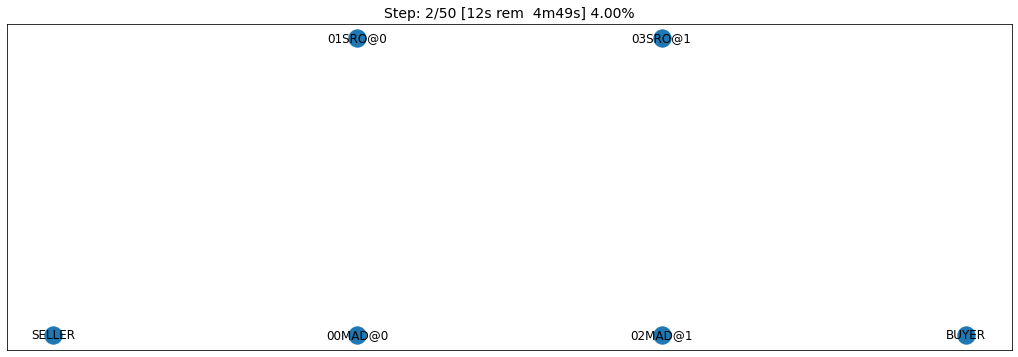

In [7]:
_, _ = world.draw()

*If you want to just test your installation (and do not care whether you get an accurate indicator of agent performance), you can set the number of steps to a small value (e.g. n_steps=10).*

Now you can run this world simulation by just calling `run`. 

In [8]:
world.run_with_progress() # may take few minutes


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


Let's see what happened in this run. Firstly, how many negotiations were conducted over time

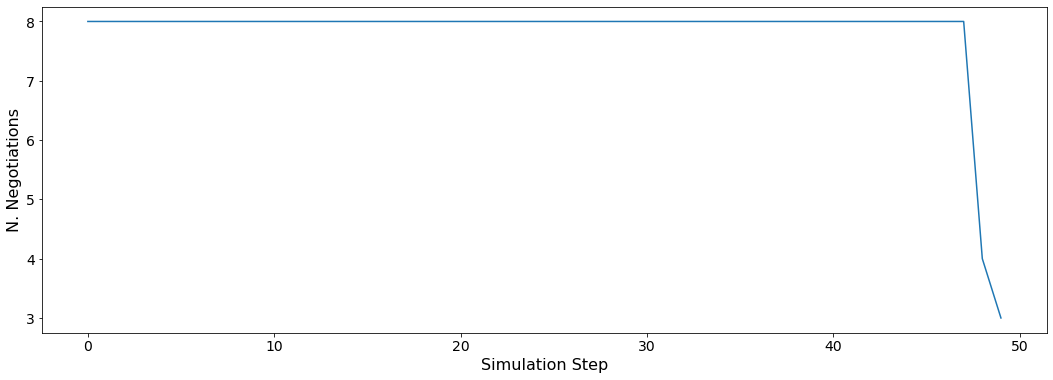

In [9]:
plt.plot(world.stats['n_negotiations'])
plt.xlabel('Simulation Step')
plt.ylabel('N. Negotiations')
plt.show()

It is clear that many negotiations happened at the beginning of the simulation with smaller number later. That is expected as the agents at the first and last production layer receive more exogenous contracts in the beginning.

Several other market statistics are available:

In [10]:
pprint(list(_ for _ in world.stats.keys() if "@" not in _  ))

['n_contracts_nullified_now',
 'n_bankrupt',
 'trading_price_0',
 'sold_quantity_0',
 'unit_price_0',
 'trading_price_1',
 'sold_quantity_1',
 'unit_price_1',
 'trading_price_2',
 'sold_quantity_2',
 'unit_price_2',
 'productivity',
 'market_size',
 'production_failures',
 'bankruptcy',
 'n_registered_negotiations_before',
 'n_contracts_executed',
 'n_contracts_erred',
 'n_contracts_nullified',
 'n_contracts_cancelled',
 'n_contracts_dropped',
 'n_breaches',
 'breach_level',
 'n_contracts_signed',
 'n_contracts_concluded',
 'n_negotiations',
 'n_negotiation_rounds_successful',
 'n_negotiation_rounds_failed',
 'n_negotiation_successful',
 'n_negotiation_failed',
 'n_registered_negotiations_after',
 'activity_level',
 'step_time',
 'total_time']


Let's start by seeing how long did each step take (note that `stats` access the stats as a Dict[str, List] but `stats_df` access the same data as a pandas dataframe.

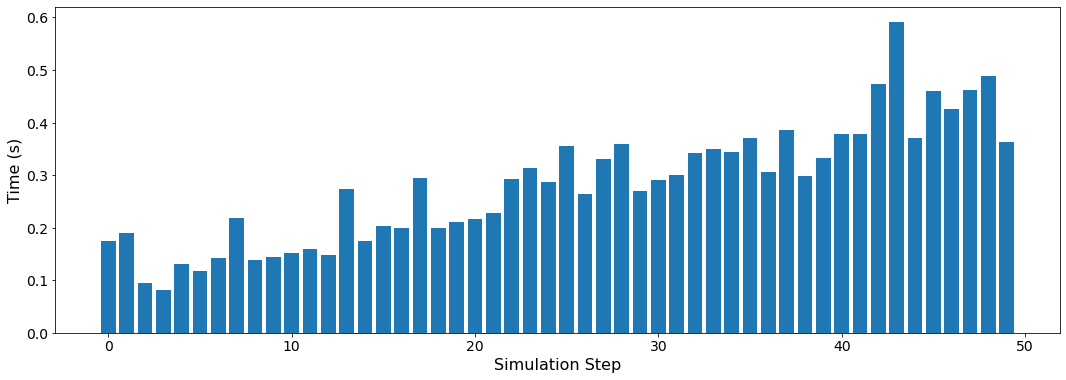

In [11]:
plt.bar(range(world.n_steps), world.stats_df['step_time'])
plt.xlabel('Simulation Step')
plt.ylabel('Time (s)')
plt.show()

There are statistics specific for each agent that all have "_{agent_name}". Lets check what is available for the winner agent:

In [12]:
winner = world.winners[0]
pprint(list(_ for _ in world.stats.keys() if winner.name in _ ))

['spot_market_quantity_03SRO@1',
 'spot_market_loss_03SRO@1',
 'balance_03SRO@1',
 'inventory_03SRO@1_input',
 'inventory_03SRO@1_output',
 'productivity_03SRO@1',
 'assets_03SRO@1',
 'bankrupt_03SRO@1',
 'score_03SRO@1']


The convension is that agent names has the form {ind}{Type}{process} where **ind** is a unique index, **Type** is a shortened version of the agent's type name, and **process** is the process the agnet can run. Note that the agent's input product has the same number as its process and its output product has the next number (i.e. an agent that runs process 1, has input product 1 and output product 2).

We can see that 8 pieces of information are available (for each time-step of the simulation):

- **bankrupt** If true, the agent is bankrupt.
- **balance** The money the agent has in its wallet (account).
- **inventory (input)** The number of units of the agent's input product available in its inventory (by the end of the simulation step).
- **inventory (output)** The number of units of the agent's output product available in its inventory (by the end of the simulation step).
- **assets** The value of the agent's assets (input and output products in inventory) evaluated at the trading price
- **spot market quantity** The quantity bought by this agent from the spot market (of its output product on this step). This can only happen as a result of a product-breach.
- **spot market loss** The spot market price for the agent. This value will go up the more the agent buys from the spot market and will be used to calculate the price for this agent at future steps. This way agents that depend on the spot market instead of negotiation get punished.
- **productivity** The fraction of the agent's production lines that were active at a given time-step.
- **score** The score of the agent according to the evaluation rule of ANAC SCML 2020

Let's see how did our agent do

In [13]:
#show the first and last value of each of the agent statistics
pprint({k:(v[0], v[-1]) for k, v in world.stats.items() if winner.name in k })

{'assets_03SRO@1': (0.0, 193.52469401484882),
 'balance_03SRO@1': (24439, 21557),
 'bankrupt_03SRO@1': (False, False),
 'inventory_03SRO@1_input': (0, 12),
 'inventory_03SRO@1_output': (0, 0),
 'productivity_03SRO@1': (0.1, 0.0),
 'score_03SRO@1': (1.0, 0.8851250376310112),
 'spot_market_loss_03SRO@1': (0.3, 4.7565),
 'spot_market_quantity_03SRO@1': (0, 1)}


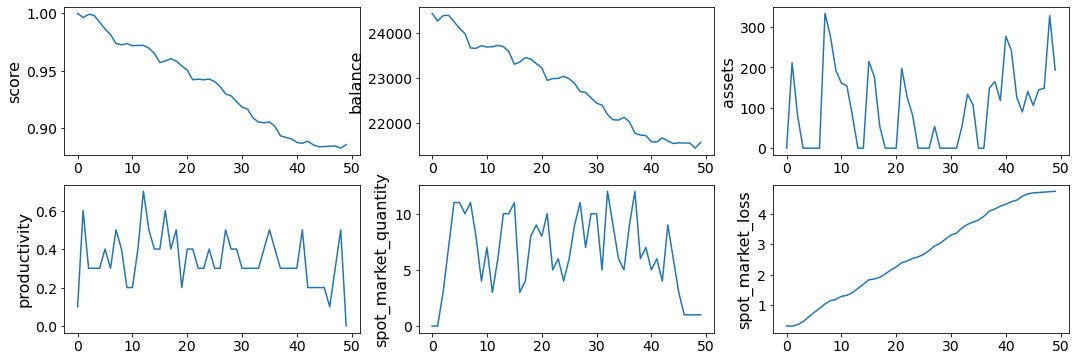

In [14]:
stats = pd.DataFrame(data=world.stats)
fig, axs = plt.subplots(2, 3)
for ax, key in zip(axs.flatten().tolist(), ["score", "balance", "assets", "productivity", 
                         "spot_market_quantity", "spot_market_loss"]):
    ax.plot(stats[f"{key}_{winner}"])
    ax.set(ylabel=key)
fig.show()

We can for example check the activity level of this world (defined as the total amount of money transferred due to trade)

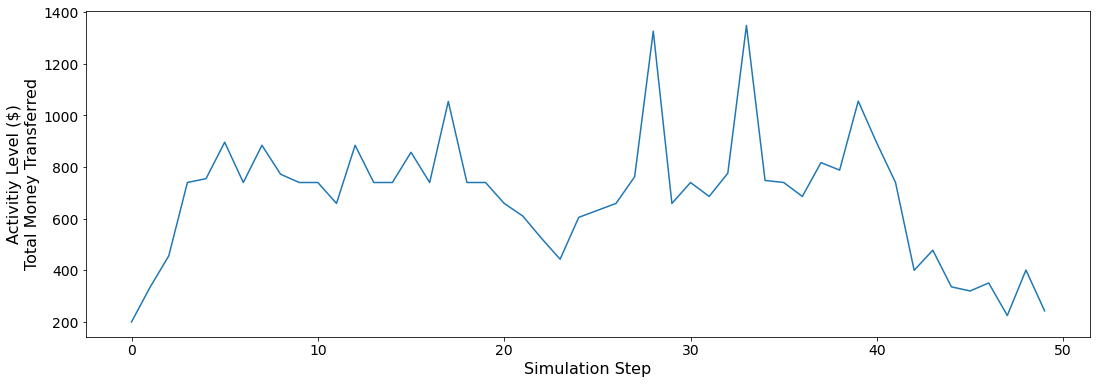

In [15]:
plt.plot(world.stats['activity_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Activitiy Level ($)\nTotal Money Transferred')
plt.show()

We can see a picture of contracting in this world as follows:

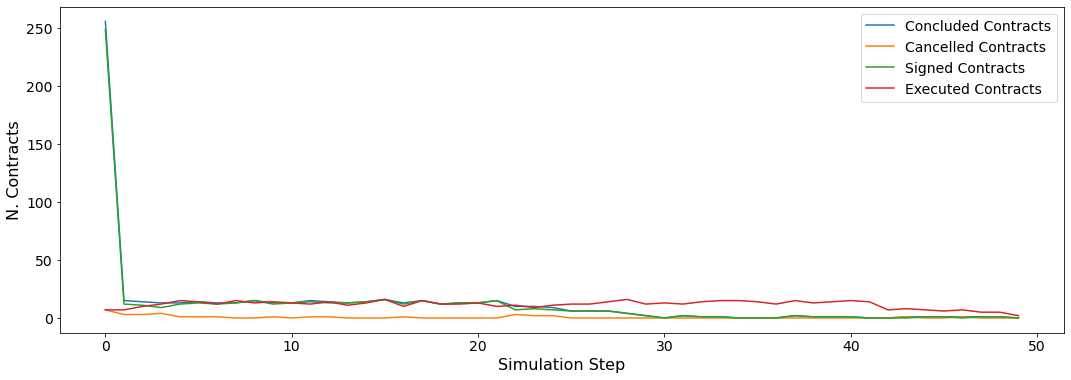

In [16]:
plt.plot(world.stats['n_contracts_concluded'], label='Concluded Contracts')
plt.plot(world.stats['n_contracts_cancelled'], label='Cancelled Contracts') 
plt.plot(world.stats['n_contracts_signed'], label='Signed Contracts') 
plt.plot(world.stats['n_contracts_executed'], label='Executed Contracts')
plt.legend()
plt.xlabel('Simulation Step')
plt.ylabel('N. Contracts')
plt.show()

We can also check the breaches that happened

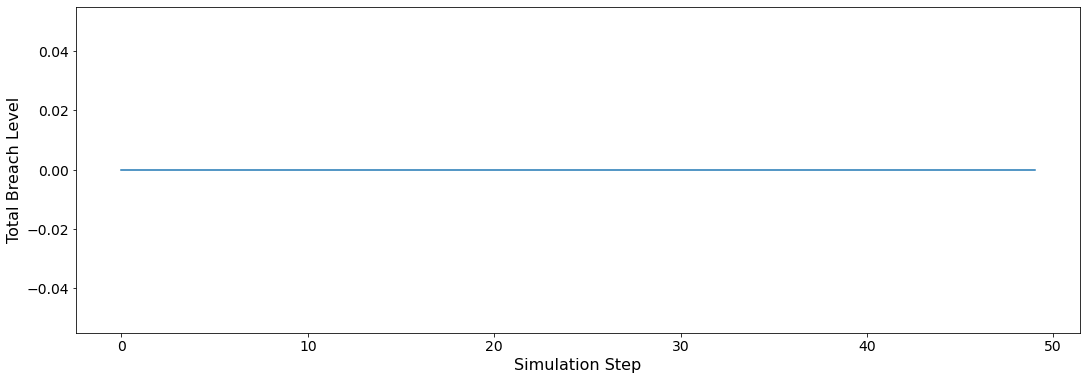

In [17]:
plt.plot(world.stats['breach_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Total Breach Level')
plt.show()

Notice that there can be multiple winners

In [18]:
winner_profits = [100 * world.scores()[_.id] for _ in world.winners]
winner_types = [_.short_type_name for _ in world.winners]
print(f"{world.winners} of type {winner_types} won at {winner_profits}%")

[03SRO@1] of type ['syncrandomoneshot:syncrandomoneshot'] won at [88.51250376310112]%


Let's check how did the first winner's inventory changes over time:

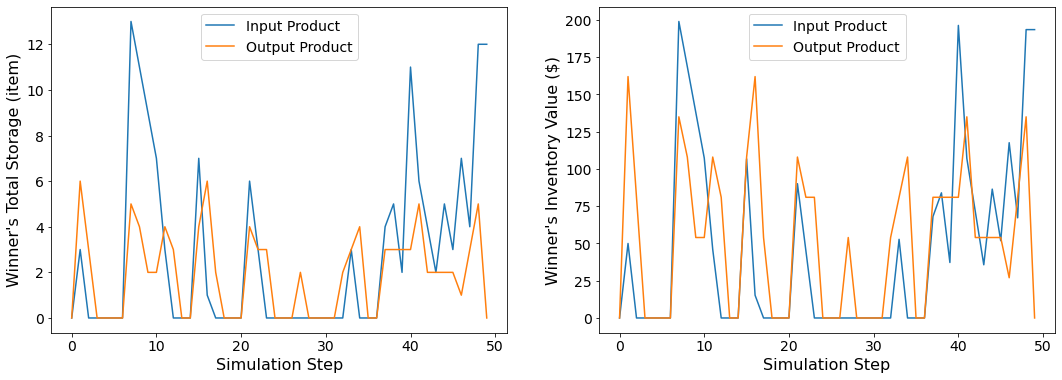

In [19]:
# find the keys in stats for the input and output inventory
in_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_input')][0]
out_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_output')][0]

# find input and output product indices
input_product, output_product = winner.awi.my_input_product, winner.awi.my_output_product
# draw
fig, (quantity, value) = plt.subplots(1, 2)
quantity.plot(world.stats[in_key], label=f"Input Product")
quantity.plot(world.stats[out_key], label=f"Output Product")
quantity.set(xlabel='Simulation Step', ylabel='Winner\'s Total Storage (item)')
quantity.legend()
value.plot(np.array(world.stats[in_key]) * np.array(world.stats[f"trading_price_{input_product}"])
              , label=f"Input Product")
value.plot(np.array(world.stats[out_key]) * np.array(world.stats[f"trading_price_{output_product}"])
              , label=f"Output Product")
value.set(xlabel='Simulation Step', ylabel='Winner\'s Inventory Value ($)')
value.legend()
fig.show()

We can actually check what happens to ALL competitors:

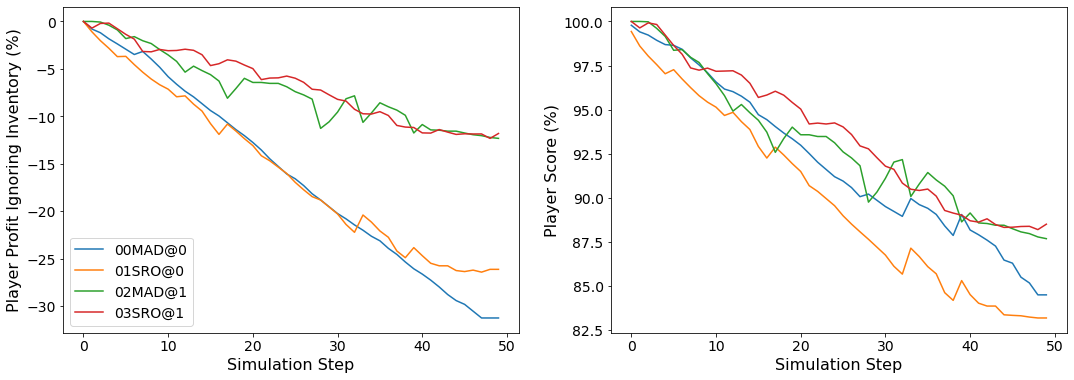

In [20]:
from scml.scml2020.world import is_system_agent
fig, (profit, score) = plt.subplots(1, 2)
snames = sorted(world.non_system_agent_names)
for name in snames:    
    profit.plot(100.0 * (np.asarray(world.stats[f'balance_{name}'])/world.stats[f'balance_{name}'][0] - 1.0), label=name)
    score.plot(100 * np.asarray(world.stats[f'score_{name}']), label=name)
profit.set(xlabel='Simulation Step', ylabel='Player Profit Ignoring Inventory (%)')
profit.legend(loc='lower left')
score.set(xlabel='Simulation Step', ylabel='Player Score (%)')
fig.show()

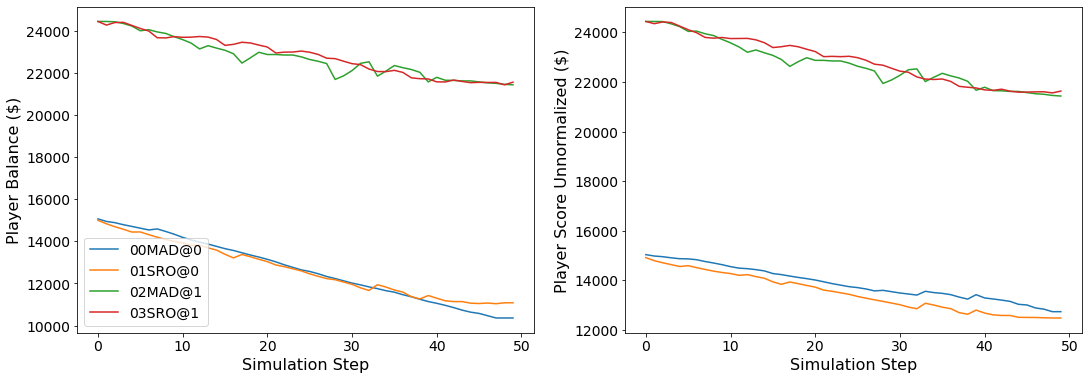

In [21]:
from scml.scml2020.world import is_system_agent
fig, (profit, score) = plt.subplots(1, 2)
snames = sorted(world.non_system_agent_names)
for name in snames:    
    profit.plot((np.asarray(world.stats[f'balance_{name}'])), label=name)
    score.plot(np.asarray(world.stats[f'score_{name}'])*(world.stats[f'balance_{name}'][0]), label=name)
profit.set(xlabel='Simulation Step', ylabel='Player Balance ($)')
profit.legend(loc='lower left')
score.set(xlabel='Simulation Step', ylabel='Player Score Unnormalized ($)')
fig.show()

or just look at the end of the game

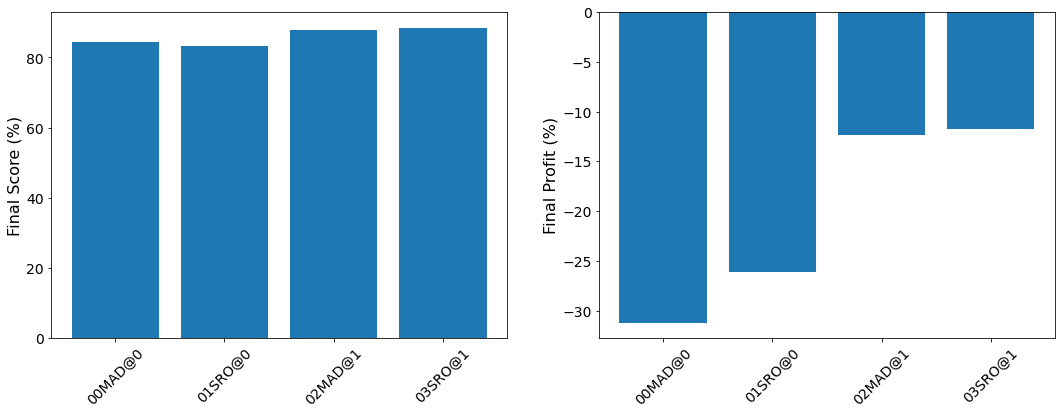

In [22]:
fig, (score, profit) = plt.subplots(1, 2)
final_scores = [100 * world.stats[f"score_{_}"][-1] 
                for _ in world.non_system_agent_names]
final_profits = [100 * world.stats[f"balance_{_}"][-1] / world.stats[f"balance_{_}"][0] - 100 
                 for _ in world.non_system_agent_names]
plt.setp(score.xaxis.get_majorticklabels(), rotation=45)
plt.setp(profit.xaxis.get_majorticklabels(), rotation=45)
score.bar(world.non_system_agent_names, final_scores)
profit.bar(world.non_system_agent_names, final_profits)
score.set(ylabel="Final Score (%)")
profit.set(ylabel="Final Profit (%)")

fig.show()

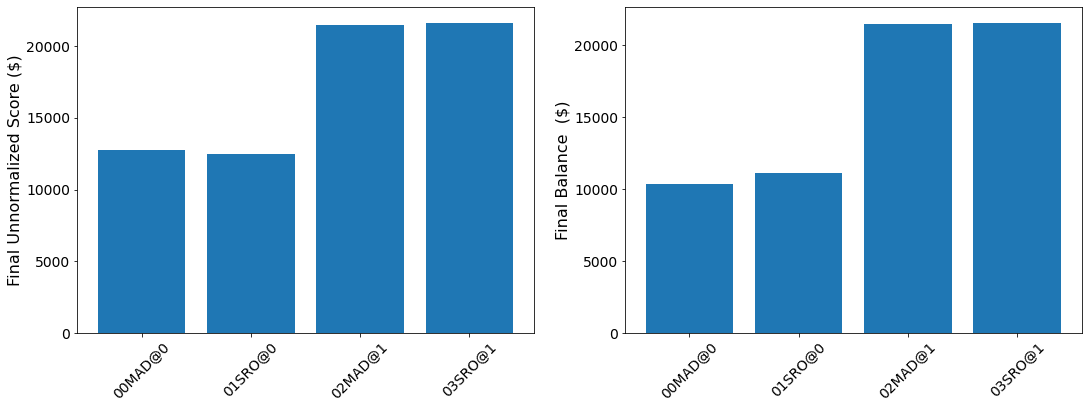

In [23]:
fig, (score, profit) = plt.subplots(1, 2)
final_scores = [world.stats[f"score_{_}"][-1] * (world.stats[f"balance_{_}"][0]) 
                for _ in world.non_system_agent_names]
final_profits = [world.stats[f"balance_{_}"][-1] 
                 for _ in world.non_system_agent_names]
plt.setp(score.xaxis.get_majorticklabels(), rotation=45)
plt.setp(profit.xaxis.get_majorticklabels(), rotation=45)
score.bar(world.non_system_agent_names, final_scores)
profit.bar(world.non_system_agent_names, final_profits)
score.set(ylabel="Final Unnormalized Score ($)")
profit.set(ylabel="Final Balance  ($)")

fig.show()

You can inspect what happened in the simulation by plotting different output statistics. For example, we can see how did the trading price of different products change over the simulation time.

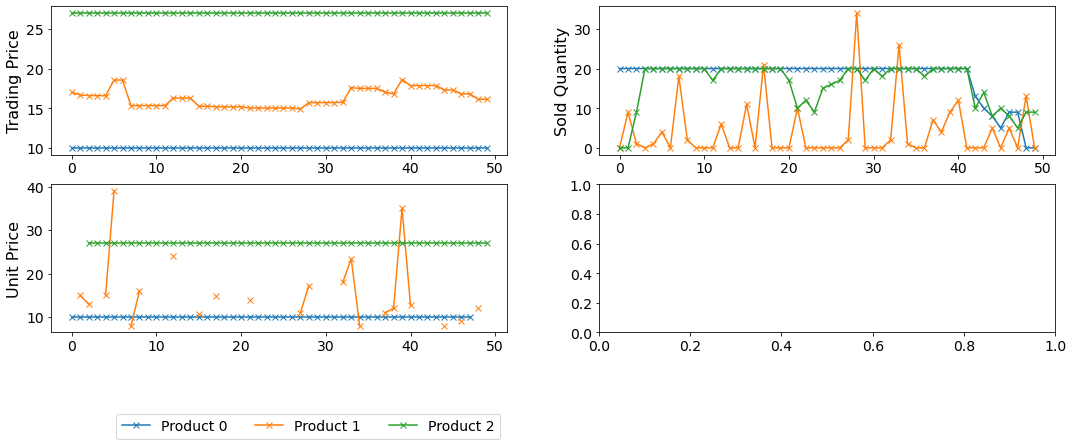

In [24]:
fig, axs = plt.subplots(2, 2)
for ax, key in zip(axs.flatten().tolist(), ["trading_price", "sold_quantity", "unit_price"]):
    for p in range(world.n_products):
        ax.plot(world.stats[f"{key}_{p}"], marker="x", label=f"Product {p}")
        ax.set_ylabel(key.replace("_", " ").title())
        ax.legend().set_visible(False)
axs[-1, 0].legend(bbox_to_anchor=(1, -.5), ncol=3)
fig.show()

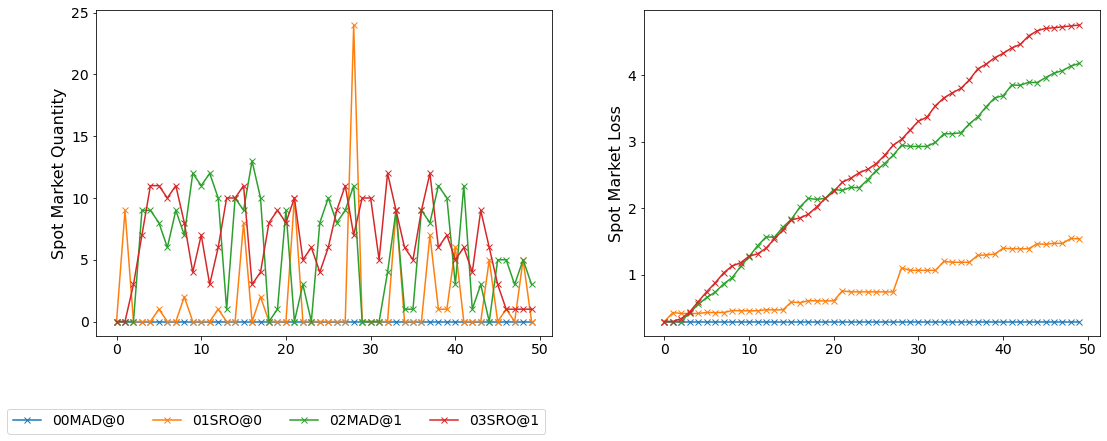

In [25]:
fig, axs = plt.subplots(1, 2)
for ax, key in zip(axs.flatten().tolist(), ["spot_market_quantity", "spot_market_loss"]):
    for a in world.non_system_agent_names:
        ax.plot(world.stats[f"{key}_{a}"], marker="x", label=f"{a}")
        ax.set_ylabel(key.replace("_", " ").title())
        ax.legend().set_visible(False)
axs[0].legend(bbox_to_anchor=(1, -.2), ncol=4)
fig.show()

You can dig futher to understand what happened during this siumulation. For example, let's see some of the contracts that were signed:

In [26]:
# create a view with only signed contracts
contracts = world.contracts_df
signed = contracts.loc[contracts.signed_at>=0, :]

In [27]:
fields = ["seller_name", "buyer_name", "delivery_time", "quantity", "unit_price",
          "signed_at", "executed", "breached", "nullified", "erred"]
signed[fields].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,executed,breached,nullified,erred
593,01SRO@0,02MAD@1,28,21,18,28,True,False,False,False
598,01SRO@0,02MAD@1,33,20,28,31,True,False,False,False
451,01SRO@0,02MAD@1,17,20,15,15,True,False,False,False
317,00MAD@0,03SRO@1,7,18,8,5,True,False,False,False
570,01SRO@0,02MAD@1,28,13,16,24,True,False,False,False
530,01SRO@0,03SRO@1,21,10,14,21,True,False,False,False
604,01SRO@0,02MAD@1,39,9,35,38,True,False,False,False
262,01SRO@0,03SRO@1,1,9,15,1,True,False,False,False
611,01SRO@0,03SRO@1,48,9,10,47,True,False,False,False
94,02MAD@1,BUYER,16,8,27,0,True,False,False,False


Let's check some of the contracts that were fully executed

In [28]:
signed.loc[signed.executed, fields].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,executed,breached,nullified,erred
593,01SRO@0,02MAD@1,28,21,18,28,True,False,False,False
598,01SRO@0,02MAD@1,33,20,28,31,True,False,False,False
451,01SRO@0,02MAD@1,17,20,15,15,True,False,False,False
317,00MAD@0,03SRO@1,7,18,8,5,True,False,False,False
570,01SRO@0,02MAD@1,28,13,16,24,True,False,False,False
530,01SRO@0,03SRO@1,21,10,14,21,True,False,False,False
604,01SRO@0,02MAD@1,39,9,35,38,True,False,False,False
262,01SRO@0,03SRO@1,1,9,15,1,True,False,False,False
611,01SRO@0,03SRO@1,48,9,10,47,True,False,False,False
94,02MAD@1,BUYER,16,8,27,0,True,False,False,False


In [29]:
signed.loc[signed.breached, fields[:-4] + ["breaches"]].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,breaches


We can now see how does the singning day affect delivery day, product and quantity

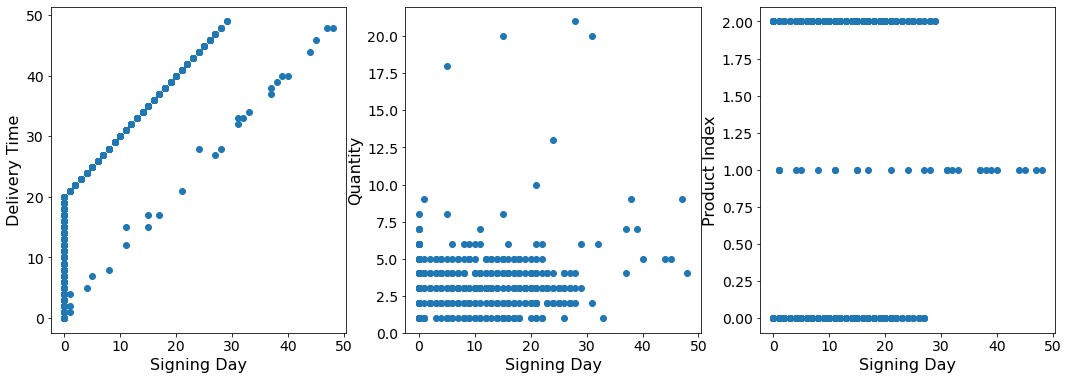

In [30]:
fig, ax = plt.subplots(1, 3)
for i, x in enumerate(["delivery_time", "quantity", "product_index"]):
    ax[i].scatter(signed.signed_at, signed[x])
    ax[i].set(ylabel=x.replace("_", " ").title(), xlabel="Signing Day")
fig.show()

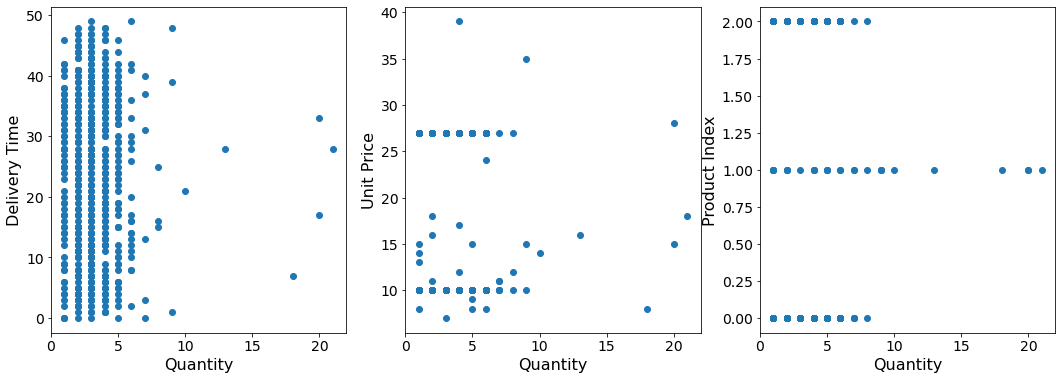

In [31]:
fig, ax = plt.subplots(1, 3)
for i, x in enumerate(["delivery_time", "unit_price", "product_index"]):
    ax[i].scatter(signed.quantity, signed[x])
    ax[i].set(ylabel=x.replace("_", " ").title(), xlabel="Quantity")
fig.show()

Did any agents go bankrupt and when?

In [32]:
bankruptcy = {a: np.nonzero(stats[f"bankrupt_{a}"].values)[0]
        for a in world.non_system_agent_names}
pprint({k: "No" if len(v)<1 else f"at: {v[0]}" for k, v in bankruptcy.items()})

{'00MAD@0': 'No', '01SRO@0': 'No', '02MAD@1': 'No', '03SRO@1': 'No'}


You can see what happened during this simulation by drawing graphs at different steps.
The meaning of different edge colors can be drawn as follows:

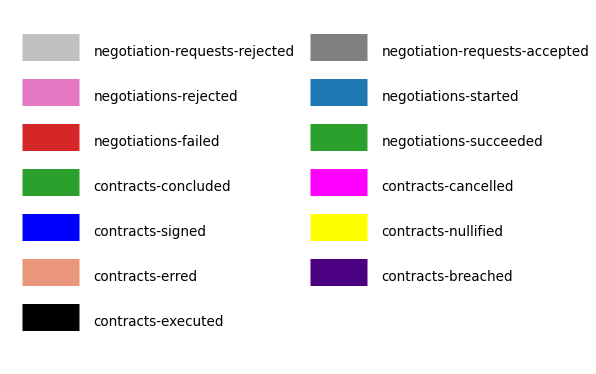

In [33]:
from negmas import show_edge_colors
show_edge_colors()

You can see what happened in this world in a series of graphs using the `draw` method

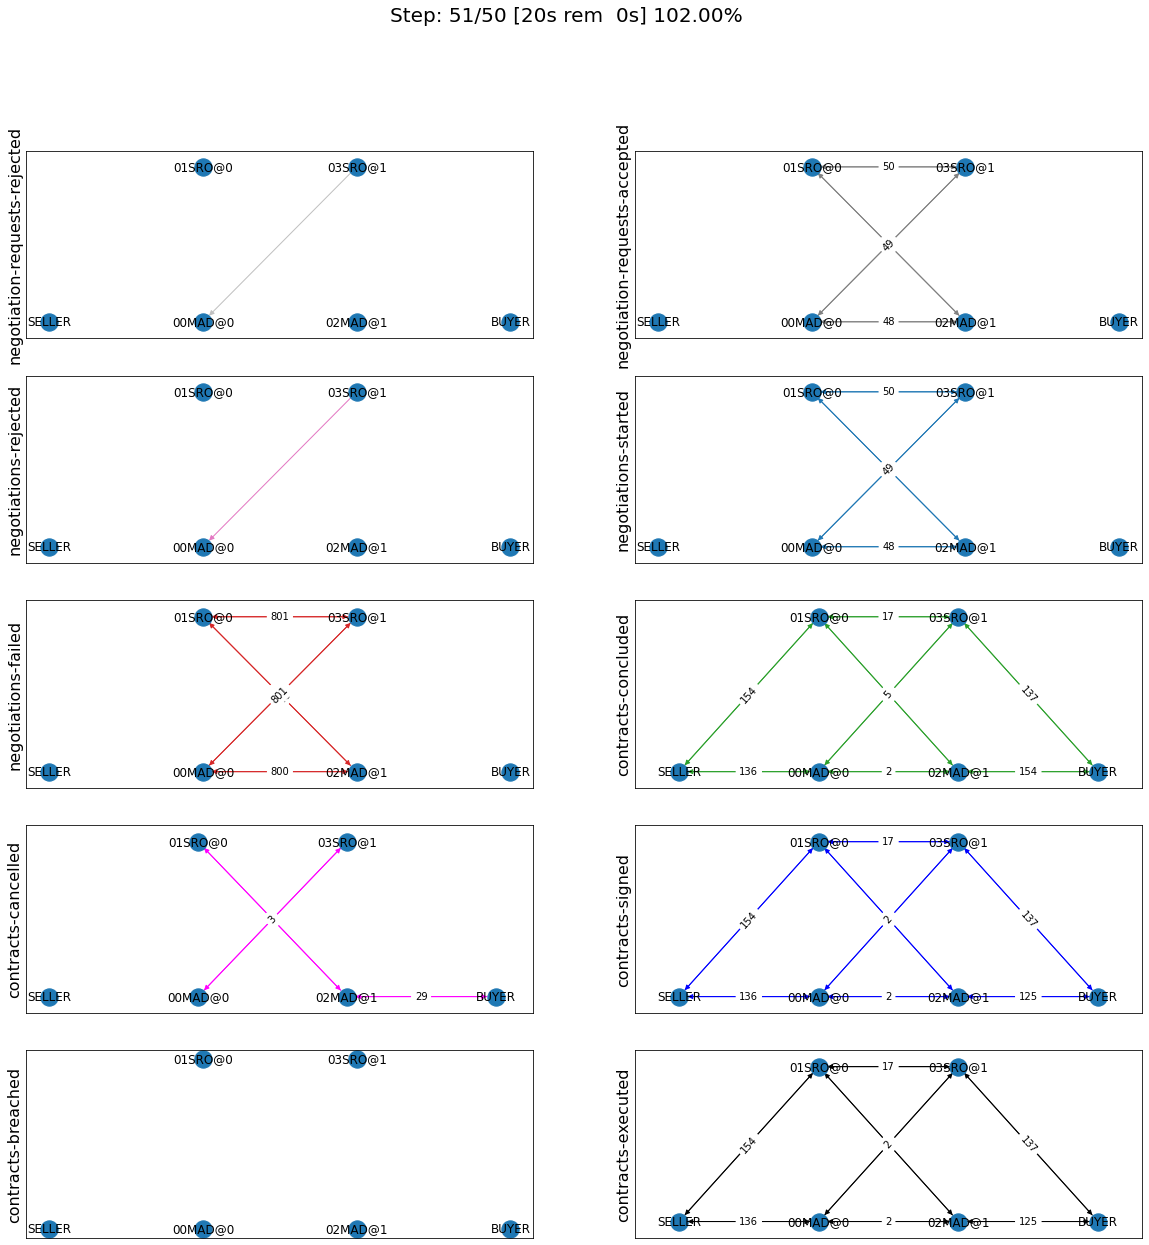

In [34]:
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

You can also run a simple animation to see what happens at every step (you need to download the jupyter notebook and execute it to see the animation) :

In [35]:
world.save_gif("run.gif")

[]

then show the animation

In [36]:
from IPython.display import HTML
HTML('<img src="run.gif">')

## Running a tournament
    
Now that you can run simple world simulations, let's try to run a complete tournament and see its results.
Let's start by running a standard tournament (in which each agent is represented by a single factory). Running a collusion tournament will be exactly the same with the only difference that `anac2021_std` will be replaced with `anac2021_collusion`.Running a one-shot tournament (new in 2021) similarily just requires a change from `anac2021_std` to `anac2021_oneshot`

Note that in the real competition we use thousands of configurations  and longer simulation steps (e.g. 50 $\le$ n_steps $\le$ 500). 

In [37]:
from scml.scml2020.utils import anac2021_std
pd.options.display.float_format = '{:,.2f}'.format
def shorten_names(results):
    # just make agent types more readable
    results.score_stats.agent_type = results.score_stats.agent_type.str.split(".").str[-1]
    results.kstest.a = results.kstest.a.str.split(".").str[-1]
    results.kstest.b = results.kstest.b.str.split(".").str[-1]
    results.total_scores.agent_type = results.total_scores.agent_type.str.split(".").str[-1]
    results.scores.agent_type = results.scores.agent_type.str.split(".").str[-1]
    results.winners = [_.split(".")[-1] for _ in results.winners]
    return results

In [38]:
tournament_types = [
    DecentralizingAgent, MarketAwareDecentralizingAgent, SyncRandomOneShotAgent
]
# may take a long time
results = anac2021_std(
    competitors=tournament_types,  
    n_configs=5, # number of different configurations to generate 
    n_runs_per_world=1, # number of times to repeat every simulation (with agent assignment)
    n_steps = 10, # number of days (simulation steps) per simulation
    print_exceptions=True,
) 


In [39]:
results = shorten_names(results)

Who was the winner?

In [40]:
results.winners

['MarketAwareDecentralizingAgent']

How many simulations were actually run?

In [41]:
len(results.scores.run_id.unique())

15

The total number of simulations $n_{s}$ will be $n_t \times n_c \times n_r$ where $n_t$ is the number of competitor agent types, $n_c$ is the number of configurations, and $n_r$ is the number of runs per configuration


We can also see the scores that every agent type got

In [42]:
results.score_stats

,agent_type,count,mean,std,min,25%,50%,75%,max
0,SyncRandomOneShotAgent,15.00,-1.19,0.88,-2.94,-1.70,-0.95,-0.50,-0.08
1,DecentralizingAgent,15.00,-0.21,0.13,-0.42,-0.30,-0.23,-0.12,0.00
2,MarketAwareDecentralizingAgent,15.00,-0.16,0.09,-0.39,-0.21,-0.14,-0.11,-0.04


You can also do statistical significance testing using ttest or kstest (with multi-comparison correction)

In [43]:
results.kstest

,a,b,t,p,n_a,n_b,n_effective
0,DecentralizingAgent,SyncRandomOneShotAgent,0.73,0.00,15,15,15
1,DecentralizingAgent,MarketAwareDecentralizingAgent,0.40,0.18,15,15,15
2,SyncRandomOneShotAgent,MarketAwareDecentralizingAgent,0.80,0.00,15,15,15


see the total score

In [44]:
results.total_scores

,agent_type,score
0,MarketAwareDecentralizingAgent,-0.16
1,DecentralizingAgent,-0.21
2,SyncRandomOneShotAgent,-1.19


or the aggregated statistics of the world. For example, let's draw the activity level for different simulations.

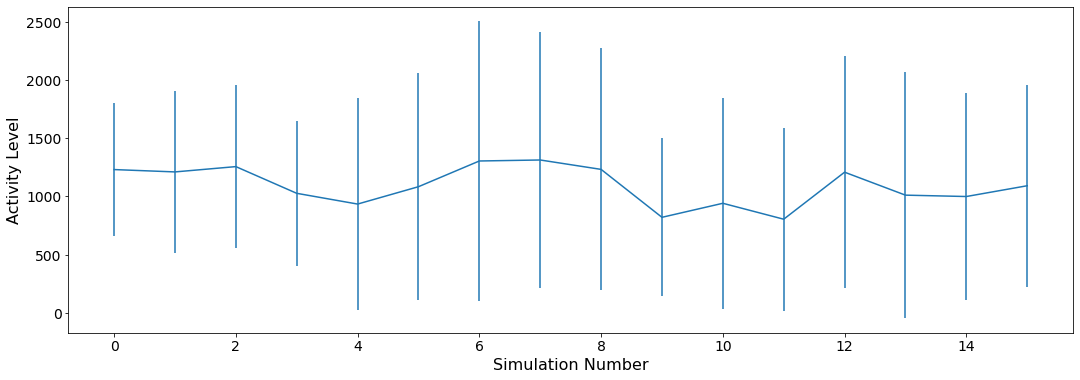

In [45]:
plt.errorbar(range(len(results.agg_stats)),
             results.agg_stats.activity_level_mean, 
             np.sqrt(results.agg_stats.activity_level_var)
             )
plt.xlabel("Simulation Number")
plt.ylabel("Activity Level")
plt.show()

We can even get the scores of every agent belonging to every agent type at every simulation

In [46]:
results.scores.loc[:, ["agent_name", "agent_type", "score"]].head()

,agent_name,agent_type,score
0,00Dec@0,DecentralizingAgent,-0.23
1,06SRO@2,SyncRandomOneShotAgent,-0.37
2,07MAD@2,MarketAwareDecentralizingAgent,-0.04
3,00MAD@0,MarketAwareDecentralizingAgent,-0.21
4,06Dec@2,DecentralizingAgent,-0.23


Let's see how did the location at the production graph affect the score of each type.

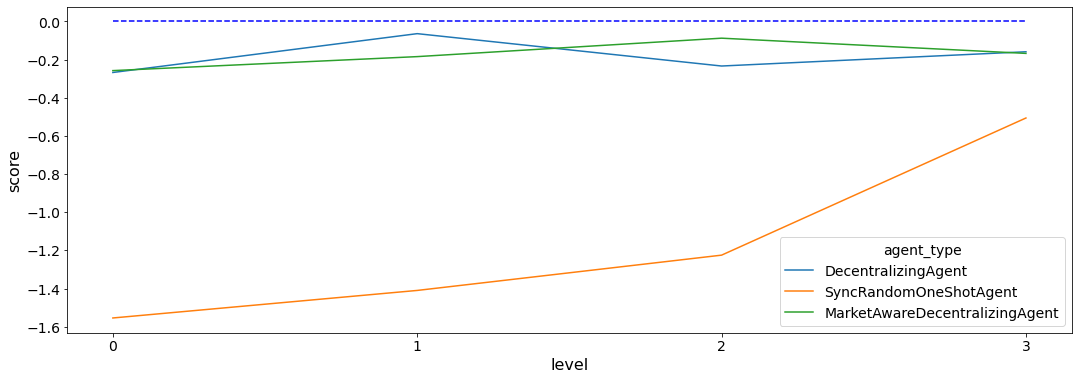

In [47]:
results.scores["level"] = results.scores.agent_name.str.split("@", expand=True).loc[:, 1]
results.scores = results.scores.sort_values("level")
sns.lineplot(data=results.scores[["agent_type", "level", "score"]], 
             x="level", y="score", hue="agent_type", ci=None)
plt.plot([0.0] * len(results.scores["level"].unique()), "b--")
plt.show()

## Running a One-Shot tournament
    
In 2021, a new track was introduced to the SCM league called the SCML-OneShot track which simplified the problem in order to focus research efforts on the core many-to-many concurrent negotiation challeng. You can run a tournament for this league in almost the same way as we did with standard/collusion tournaments using `anac2021_oneshot`

Note that in the real competition we use thousands of configurations  and longer simulation steps (e.g. 50 $\le$ n_steps $\le$ 500). 

In [48]:
from scml.scml2020.utils import anac2021_oneshot

In [49]:
tournament_types = [RandomOneShotAgent, SyncRandomOneShotAgent, GreedyOneShotAgent, GreedySingleAgreementAgent]
# may take a long time
results = anac2021_oneshot(
    competitors=tournament_types,  
    n_configs=5, # number of different configurations to generate 
    n_runs_per_world=1, # number of times to repeat every simulation (with agent assignment)
    n_steps = 10, # number of days (simulation steps) per simulation
    print_exceptions=True,
) 
results = shorten_names(results)

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/yasser/.pyenv/versions/3.9.2/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/yasser/code/projects/negmas/negmas/tournaments/tournaments.py", line 907, in _run_worlds
    if not world.step():
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3444, in step
    operation_map[operation]()
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3241, in _simulation_step
    raise (e)
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3235, in _simulation_step
    self.simulation_step(stage)
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/world.py", line 1288, in simulation_step
    a.before_step()
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/sysagents.py", line 69, in before_step
    self._obj.be

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/yasser/.pyenv/versions/3.9.2/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/yasser/code/projects/negmas/negmas/tournaments/tournaments.py", line 907, in _run_worlds
    if not world.step():
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3444, in step
    operation_map[operation]()
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3241, in _simulation_step
    raise (e)
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3235, in _simulation_step
    self.simulation_step(stage)
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/world.py", line 1288, in simulation_step
    a.before_step()
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/sysagents.py", line 69, in before_step
    self._obj.be

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/yasser/.pyenv/versions/3.9.2/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/yasser/code/projects/negmas/negmas/tournaments/tournaments.py", line 907, in _run_worlds
    if not world.step():
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3444, in step
    operation_map[operation]()
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3241, in _simulation_step
    raise (e)
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3235, in _simulation_step
    self.simulation_step(stage)
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/world.py", line 1288, in simulation_step
    a.before_step()
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/sysagents.py", line 69, in before_step
    self._obj.be

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/yasser/.pyenv/versions/3.9.2/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/yasser/code/projects/negmas/negmas/tournaments/tournaments.py", line 907, in _run_worlds
    if not world.step():
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3444, in step
    operation_map[operation]()
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3241, in _simulation_step
    raise (e)
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3235, in _simulation_step
    self.simulation_step(stage)
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/world.py", line 1288, in simulation_step
    a.before_step()
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/sysagents.py", line 69, in before_step
    self._obj.be

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/yasser/.pyenv/versions/3.9.2/lib/python3.9/concurrent/futures/process.py", line 243, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/yasser/code/projects/negmas/negmas/tournaments/tournaments.py", line 907, in _run_worlds
    if not world.step():
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3444, in step
    operation_map[operation]()
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3241, in _simulation_step
    raise (e)
  File "/Users/yasser/code/projects/negmas/negmas/situated/situated.py", line 3235, in _simulation_step
    self.simulation_step(stage)
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/world.py", line 1288, in simulation_step
    a.before_step()
  File "/Users/yasser/code/projects/scml/src/scml/oneshot/sysagents.py", line 69, in before_step
    self._obj.be

EmptyDataError: No columns to parse from file

Who was the winner?

In [ ]:
results.winners

How many simulations were actually run?

In [ ]:
len(results.scores.run_id.unique())

The total number of simulations $n_{s}$ will be $n_t \times n_c \times n_r$ where $n_t$ is the number of competitor agent types, $n_c$ is the number of configurations, and $n_r$ is the number of runs per configuration


We can also see the scores that every agent type got

In [ ]:
results.score_stats

You can also do statistical significance testing using ttest or kstest (with multi-comparison correction)

In [ ]:
results.kstest

see the total score

In [ ]:
results.total_scores

We can even get the scores of every agent belonging to every agent type at every simulation

In [ ]:
results.scores.loc[:, ["agent_name", "agent_type", "score"]].head()

Let's see how did the location at the production graph affect the score of each type.

In [ ]:
results.scores["level"] = results.scores.agent_name.str.split("@", expand=True).loc[:, 1]
results.scores = results.scores.sort_values("level")
sns.lineplot(data=results.scores[["agent_type", "level", "score"]], 
             x="level", y="score", hue="agent_type")
plt.plot([0.0] * len(results.scores["level"].unique()), "b--")
plt.show()

Now that you can run simulations and complete tournaments, let's see how are we going to develop a new agent for the SCML2021 league $\rightarrow$